In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import tensorflow as tf 
from tensorflow.keras import models,layers
from IPython.display import HTML

In [2]:
BATCH_SIZE=32
IMAGE_SIZE=256
CHANNELS=3
EPOCHS=50

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    'PlantVillage_2/Bell_pepper/',
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2475 files belonging to 2 classes.


In [4]:
class_names=dataset.class_names
class_names

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

In [5]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(image_batch)
    print(label_batch)

(32, 256, 256, 3)
tf.Tensor(
[[[[199. 194. 198.]
   [199. 194. 198.]
   [199. 194. 198.]
   ...
   [181. 174. 181.]
   [182. 175. 182.]
   [186. 179. 186.]]

  [[196. 191. 195.]
   [196. 191. 195.]
   [196. 191. 195.]
   ...
   [183. 176. 183.]
   [186. 179. 186.]
   [191. 184. 191.]]

  [[192. 187. 191.]
   [192. 187. 191.]
   [192. 187. 191.]
   ...
   [188. 181. 188.]
   [192. 185. 192.]
   [195. 188. 195.]]

  ...

  [[191. 184. 191.]
   [192. 185. 192.]
   [139. 132. 139.]
   ...
   [ 13.  17.  28.]
   [ 12.  16.  27.]
   [ 12.  16.  27.]]

  [[171. 164. 171.]
   [173. 166. 173.]
   [202. 195. 202.]
   ...
   [ 12.  18.  30.]
   [ 12.  18.  30.]
   [ 12.  18.  30.]]

  [[158. 151. 158.]
   [182. 175. 182.]
   [155. 148. 155.]
   ...
   [ 14.  20.  32.]
   [ 14.  20.  32.]
   [ 15.  21.  33.]]]


 [[[183. 177. 187.]
   [187. 181. 191.]
   [191. 185. 195.]
   ...
   [147. 137. 145.]
   [145. 135. 143.]
   [145. 135. 143.]]

  [[185. 179. 189.]
   [188. 182. 192.]
   [190. 184. 194.]

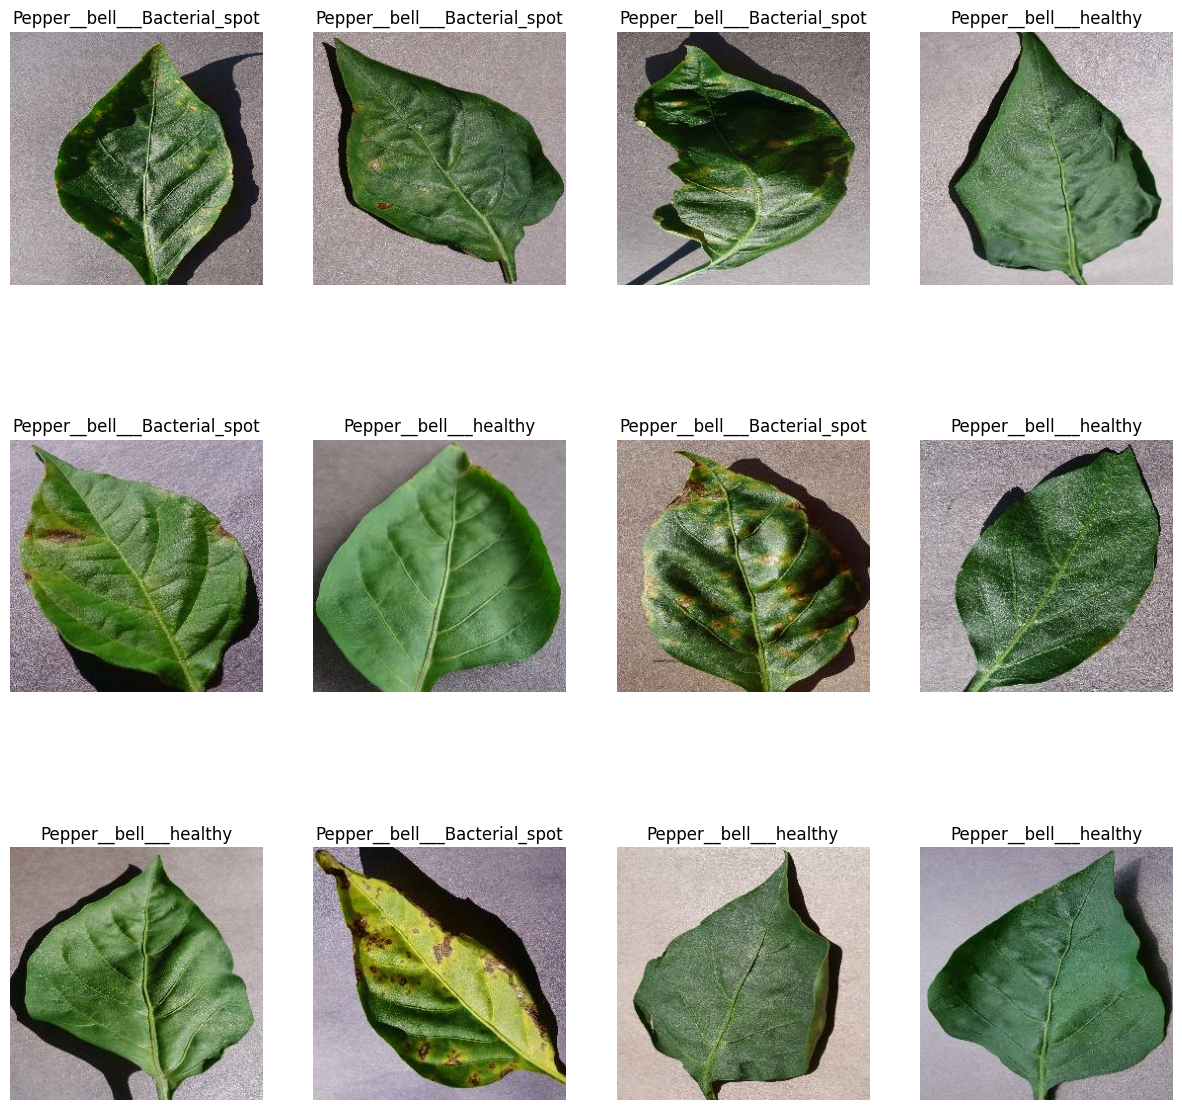

In [6]:
plt.figure(figsize=(15,15))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')
plt.show()

In [7]:
len(dataset)

78

In [8]:
78*32

2496

In [9]:
def get_train_partitions_df(ds,train_size=0.8,test_size=0.1,val_size=0.1,shuffle=True,shuffle_size=1000):
    assert (train_size+test_size+val_size)==1
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
        
    train_size=int(ds_size*train_size)
    val_size=int(ds_size*test_size)
    
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [10]:
train_ds,val_ds,test_ds=get_train_partitions_df(dataset)

In [11]:
len(train_ds)

62

In [12]:
len(test_ds)

9

In [13]:
len(val_ds)

7

In [14]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

In [16]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [17]:
train_ds=train_ds.map(
    lambda x,y : (data_augmentation(x,training=True),y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
len(train_ds)

62

In [19]:
for x, y in train_ds.take(1):
    print(x.shape, y)

(32, 256, 256, 3) tf.Tensor([1 0 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 0 0 0 0 1 1 0], shape=(32,), dtype=int32)


In [51]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=2
model=models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])
model.build(input_shape=input_shape)

In [52]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (32, 60, 60, 64)         

In [53]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [54]:
history=model.fit(train_ds,epochs=EPOCHS,batch_size=BATCH_SIZE,validation_data=val_ds,verbose=1)

Epoch 1/50
62/62 [==============================] - 16s 223ms/step - loss: 0.6049 - accuracy: 0.6648 - val_loss: 0.4778 - val_accuracy: 0.8839
Epoch 2/50
62/62 [==============================] - 14s 217ms/step - loss: 0.3185 - accuracy: 0.8681 - val_loss: 0.2526 - val_accuracy: 0.9241
Epoch 3/50
62/62 [==============================] - 13s 214ms/step - loss: 0.2211 - accuracy: 0.9165 - val_loss: 0.3887 - val_accuracy: 0.8750
Epoch 4/50
62/62 [==============================] - 14s 216ms/step - loss: 0.1145 - accuracy: 0.9628 - val_loss: 0.1005 - val_accuracy: 0.9777
Epoch 5/50
62/62 [==============================] - 14s 212ms/step - loss: 0.0684 - accuracy: 0.9822 - val_loss: 0.0497 - val_accuracy: 0.9777
Epoch 6/50
62/62 [==============================] - 13s 213ms/step - loss: 0.0514 - accuracy: 0.9822 - val_loss: 0.1008 - val_accuracy: 0.9732
Epoch 7/50
62/62 [==============================] - 13s 214ms/step - loss: 0.0512 - accuracy: 0.9873 - val_loss: 0.0129 - val_accuracy: 1.0000

In [55]:
scores=model.evaluate(test_ds)

9/9 [==============================] - 1s 45ms/step - loss: 6.3635e-04 - accuracy: 1.0000


In [56]:
scores

[0.0006363547290675342, 1.0]

In [57]:
loss=history.history['loss']
val_loss=history.history['val_loss']
accuracy=history.history['accuracy']
val_accuracy=history.history['val_accuracy']

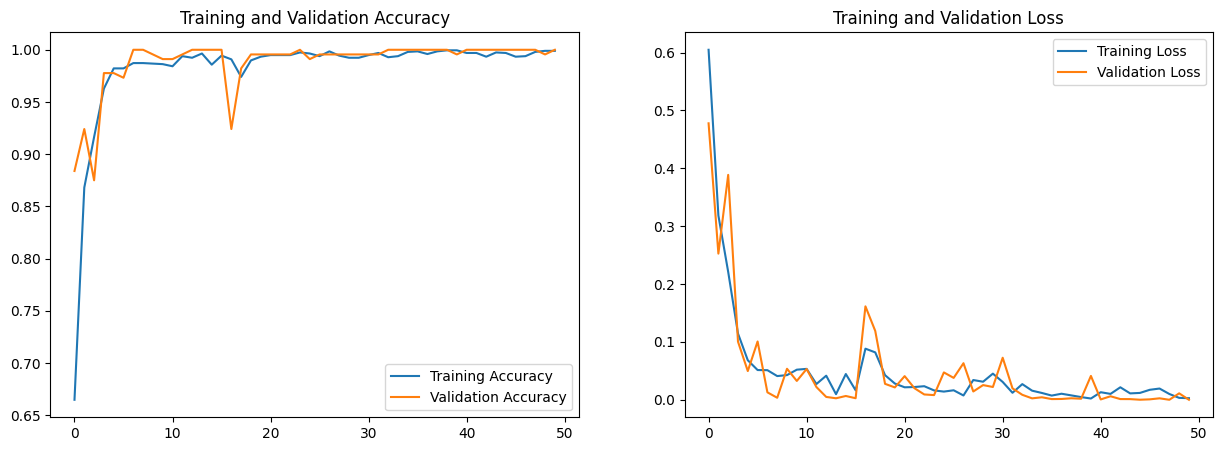

In [58]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accuracy, label='Training Accuracy')
plt.plot(range(EPOCHS), val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [59]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 46ms/step


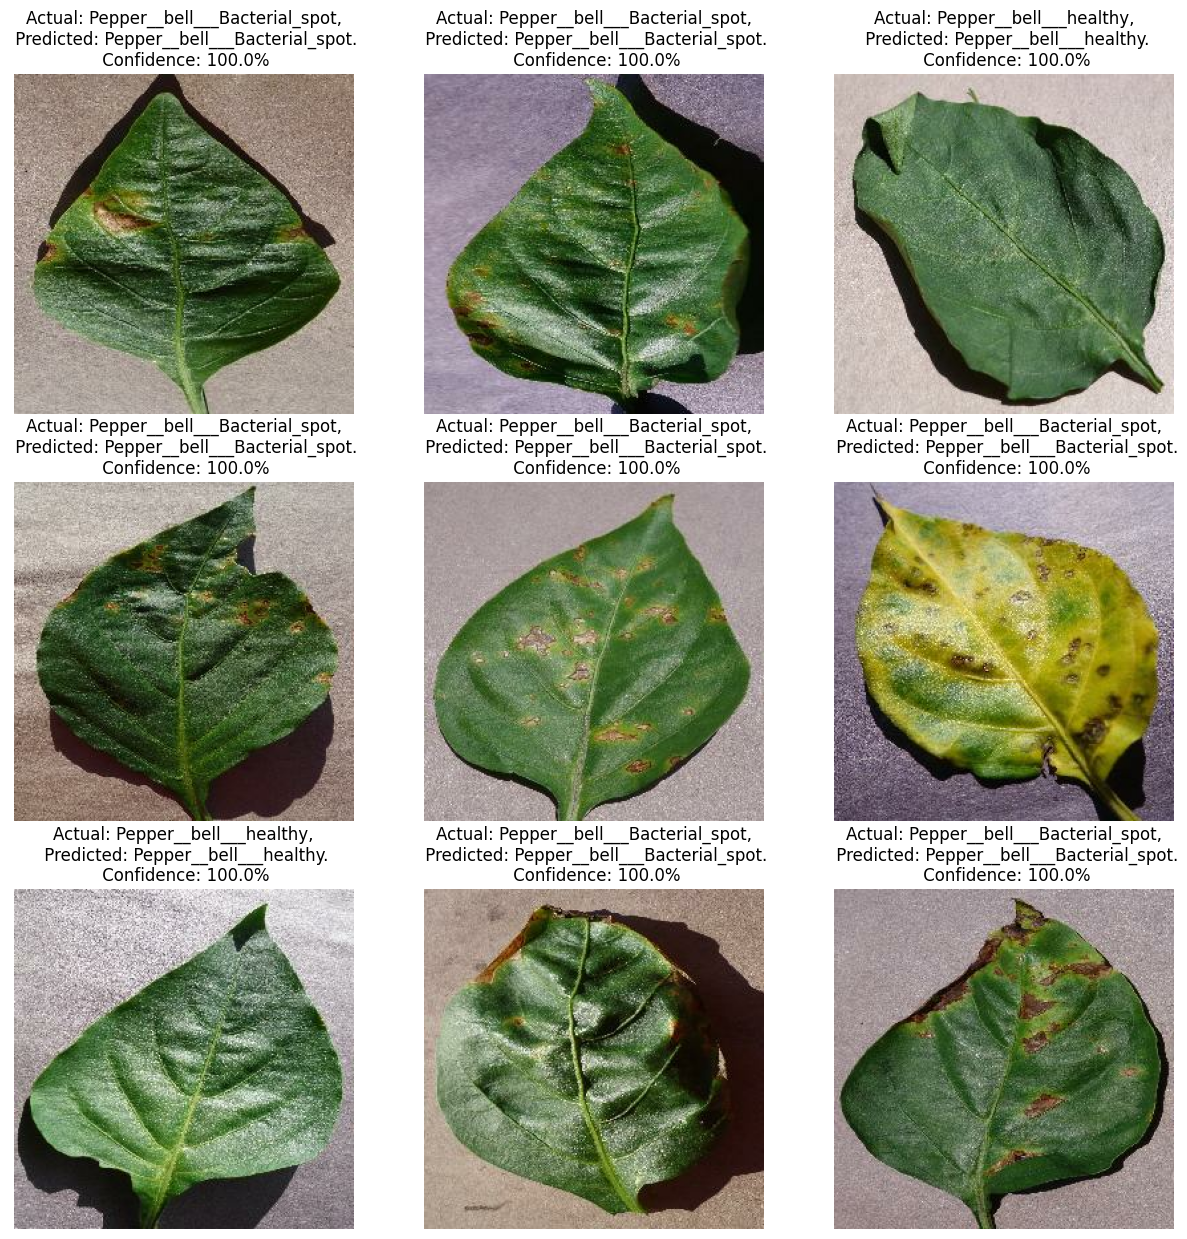

In [60]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [61]:
model_version="bell_pepper"
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/bell_pepper\assets


INFO:tensorflow:Assets written to: models/bell_pepper\assets
